<a href="https://colab.research.google.com/github/SOUMYADEEP-rgb/traffic-prediction-lstm/blob/main/traffic_jam_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# TRAFFIC CONGESTION PREDICTOR

In [36]:
import pandas as pd


sheet_url = "https://docs.google.com/spreadsheets/d/1iNJkeHnLNd50F6UzowSA9c94uxj8jIb8jLoH1Ij52_Q/gviz/tq?tqx=out:csv"
df = pd.read_csv(sheet_url)

#print(df.head())


df["timestamp"] = pd.to_datetime(df["timestamp"])

df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
weather_map = {"clear":0, "cloudy":1, "haze":2, "rainy":3}
df["weather_encoded"] = df["weather"].map(weather_map)


print(df.head())
print(df.info())


            timestamp       location      lat      lon  current_speed  \
0 2025-11-06 16:42:41      Esplanade  22.5726  88.3639             19   
1 2025-11-06 16:42:42      Salt Lake  22.5867  88.4173             26   
2 2025-11-06 16:42:42  Howrah Bridge  22.5850  88.3468             14   
3 2025-11-06 16:42:43      EM Bypass  22.4989  88.4122             20   
4 2025-11-06 16:42:44        Airport  22.6394  88.4467             19   

   free_flow_speed  confidence weather  hour  dayofweek  weather_encoded  
0               23    0.515919    haze    16          3                2  
1               26    1.000000    haze    16          3                2  
2               23    1.000000    haze    16          3                2  
3               24    0.981098    haze    16          3                2  
4               19    1.000000    haze    16          3                2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 11 columns):
 #   C

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
free_flow_dict = {
    "Esplanade": 35,
    "Salt Lake": 38,
    "Howrah Bridge": 33,
    "EM Bypass": 40,
    "Airport": 36
}

df["free_flow_speed"] = df["location"].map(free_flow_dict)


le = LabelEncoder()
df["location_encoded"] = le.fit_transform(df["location"].astype(str))


scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[["lat","lon","current_speed","free_flow_speed","confidence","hour","dayofweek","location_encoded"]])

scaler_y = MinMaxScaler()
y_speed_scaled = scaler_y.fit_transform(df[["current_speed"]])
##df["jam"] = (df["current_speed"] < 0.5 * df["free_flow_speed"]).astype(int)
def get_threshold(weather_code):
    if weather_code == 3:   # rainy
        return 0.65
    elif weather_code == 2: # haze
        return 0.60
    elif weather_code == 1: # cloudy
        return 0.55
    elif weather_code == 0: # clear
        return 0.50
    else:
        return 0.60  # default fallback just in case

# Apply jam condition dynamically
df["threshold"] = df["weather_encoded"].apply(get_threshold)

df["jam"] = (df["current_speed"] < df["free_flow_speed"] * df["threshold"]).astype(int)

df.drop(columns=["threshold"], inplace=True)

y_jam = df[["jam"]].values


In [38]:
SEQ_LEN = 12
import numpy as np

def create_sequences(X, y_speed, y_jam, seq_len):
    X_seq = []
    y_speed_seq = []
    y_jam_seq = []

    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])            # past 12 timesteps
        y_speed_seq.append(y_speed[i+seq_len])  # next speed
        y_jam_seq.append(y_jam[i+seq_len])      # next jam (0/1)

    return np.array(X_seq), np.array(y_speed_seq), np.array(y_jam_seq)

X_seq, y_speed_seq, y_jam_seq = create_sequences(X_scaled, y_speed_scaled, y_jam, SEQ_LEN)


In [39]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

inp = Input(shape=(SEQ_LEN, X_seq.shape[2]))
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(64)(x)

speed_out = Dense(32, activation="relu")(x)
speed_out = Dense(1, name="speed_output")(speed_out)

jam_out = Dense(32, activation="relu")(x)
jam_out = Dense(1, activation="sigmoid", name="jam_output")(jam_out)

model = Model(inputs=inp, outputs=[speed_out, jam_out])
model.compile(
    optimizer="adam",
    loss={"speed_output": "mse", "jam_output": "binary_crossentropy"},
    metrics={"speed_output": ["mae"], "jam_output": ["accuracy"]}
)
# -----------------------------
# 4. Train model
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_seq,
    {"speed_output": y_speed_seq, "jam_output": y_jam_seq},
    epochs=80,
    batch_size=16,
    validation_split=0.2,
    callbacks=early_stop
)



Epoch 1/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - jam_output_accuracy: 0.4736 - jam_output_loss: 0.6963 - loss: 0.8612 - speed_output_loss: 0.1650 - speed_output_mae: 0.3217 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7607 - val_loss: 0.8238 - val_speed_output_loss: 0.0657 - val_speed_output_mae: 0.2270
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - jam_output_accuracy: 0.5953 - jam_output_loss: 0.6668 - loss: 0.7096 - speed_output_loss: 0.0431 - speed_output_mae: 0.1767 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7120 - val_loss: 0.7740 - val_speed_output_loss: 0.0632 - val_speed_output_mae: 0.2225
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - jam_output_accuracy: 0.5786 - jam_output_loss: 0.6738 - loss: 0.7154 - speed_output_loss: 0.0417 - speed_output_mae: 0.1746 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7644 - val_loss: 0.8300 - val_speed_output_loss: 0.0672 - val_speed_output_mae: 0.2154
Epoch 4/80
39/39 ━━━━━━━━━━━━━━

In [31]:
print(df.columns)


Index(['timestamp', 'location', 'lat', 'lon', 'current_speed',
       'free_flow_speed', 'confidence', 'weather', 'hour', 'dayofweek',
       'weather_encoded', 'location_encoded', 'jam'],
      dtype='object')


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

pred_speed_scaled, pred_jam = model.predict(X_seq[-10:])
pred_speed = scaler_y.inverse_transform(pred_speed_scaled).flatten()
pred_jam_class = (pred_jam.flatten() > 0.5).astype(int)

actual_speed = scaler_y.inverse_transform(y_speed_seq[-10:]).flatten().astype(int)
actual_jam = y_jam_seq[-10:].flatten()

print("Predicted speeds:", pred_speed)
print("Actual speeds:", actual_speed)
print("Predicted jam (1=Jam, 0=No Jam):", pred_jam_class)
print("Actual jam:", actual_jam)

print("Accuracy (Jam Prediction):", accuracy_score(actual_jam, pred_jam_class))
print("Precision:", precision_score(actual_jam, pred_jam_class, zero_division=0))
print("Recall:", recall_score(actual_jam, pred_jam_class, zero_division=0))
print("F1 Score:", f1_score(actual_jam, pred_jam_class, zero_division=0))

speed_accuracy = np.mean(100 - (np.abs(pred_speed - actual_speed) / actual_speed * 100))
print("Speed Prediction Accuracy (%):", speed_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Predicted speeds: [19.073568 24.036161 17.53116  18.650093 17.88317  18.642502 23.943947
 17.55656  18.694504 17.892595]
Actual speeds: [23 26 13 18 19 23 26 13 20 13]
Predicted jam (1=Jam, 0=No Jam): [1 0 1 1 1 1 0 1 1 1]
Actual jam: [0 0 1 1 1 0 0 1 1 1]
Accuracy (Jam Prediction): 0.8
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571
Speed Prediction Accuracy (%): 82.49637319061989


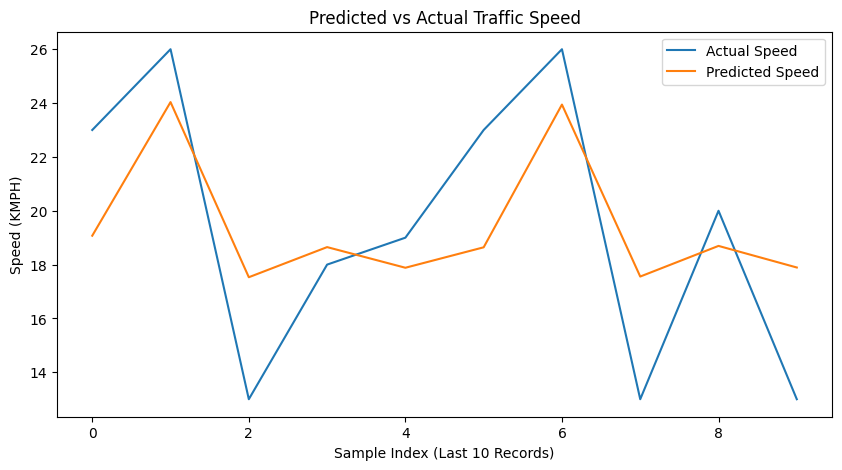

In [41]:
import matplotlib.pyplot as plt

# Plot Predicted vs Actual Speeds
plt.figure(figsize=(10,5))
plt.plot(actual_speed, label="Actual Speed")
plt.plot(pred_speed, label="Predicted Speed")
plt.xlabel("Sample Index (Last 10 Records)")
plt.ylabel("Speed (KMPH)")
plt.title("Predicted vs Actual Traffic Speed")
plt.legend()
plt.show()


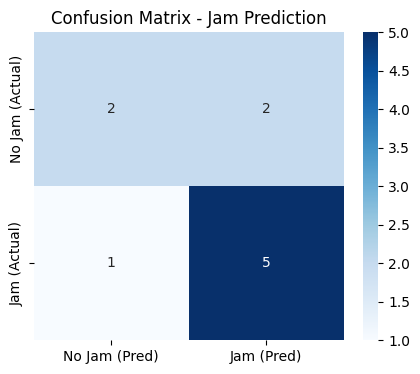

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual_jam, pred_jam_class)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Jam (Pred)", "Jam (Pred)"],
            yticklabels=["No Jam (Actual)", "Jam (Actual)"])
plt.title("Confusion Matrix - Jam Prediction")
plt.show()
